In [1]:
import pandas as pd
import numpy as np
import calculate_cleavage_rate as clv
%matplotlib inline 
import matplotlib.pylab as plt
import seaborn as sns
sns.set_style('ticks')
current_colors = sns.color_palette()
reload(clv)
import sys
import Nucleaseq_data_processing as processing
reload(processing)
import read_model_ID as model
import coarse_grain as cg
reload(cg)
reload(model)
guide = 20

sys.path.append('Toy_model')
import read_model_ID_toy as model_toy
import calculate_cleavage_rate_toy as clv_toy
reload(clv_toy)

<module 'calculate_cleavage_rate_toy' from 'Toy_model\calculate_cleavage_rate_toy.pyc'>

## Full model

C:\Users\stijn\Anaconda2\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


PAM: 2.73766502381
From solution: -3.0662109833599995
Internal: 2.80705381635
Cleavage: 0.378917952653


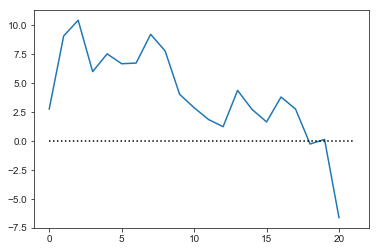

In [3]:
model_ID = 'Clv_Saturated_general_energies_v2+general_energies_no_kPR'; parnum = '44'

filename = 'fit_18_7_2019_sim_17.txt'
path = '../fits_Stijn/18_7_2019/'
data = pd.read_table(path+filename,index_col=False)
chi = data.loc[:,'Potential']
final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
final_par_np = np.array(final_par.values)

#filename = 'fit_8_8_2019_sim_3.txt'
#path = '../fits_Stijn/8_8_2019/'
#data = pd.read_table(path+filename,index_col=False)
#chi = data.loc[:,'Potential']
#final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
#final_par_np = np.array(final_par.values)


model_ID_clv,model_ID_on,parameters_clv,parameters_on = model.combined_model(final_par_np,model_ID)
energies,rates = model.unpack_parameters(parameters_on,model_ID_on,20)
_,rates_clv = model.unpack_parameters(parameters_clv,model_ID_clv,20)

plt.plot(range(0,21), -np.cumsum(np.append(-energies[0],energies[1:21])))
plt.plot([0,21],[0,0],'k:')

print 'PAM: ' + str(energies[0])
print 'From solution: ' + str(parameters_on[-2])
print 'Internal: ' + str(parameters_on[-1])
print 'Cleavage: ' + str(parameters_clv[-1])

## Coarse Graining

C:\Users\stijn\Anaconda2\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


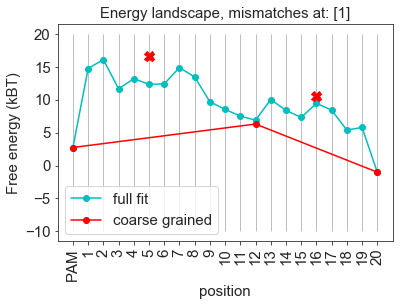

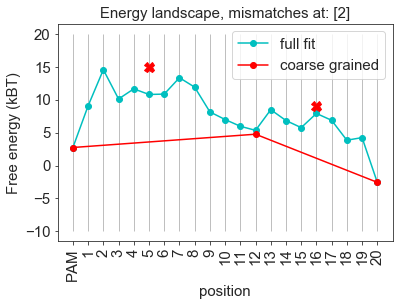

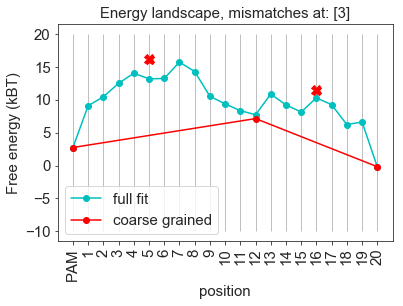

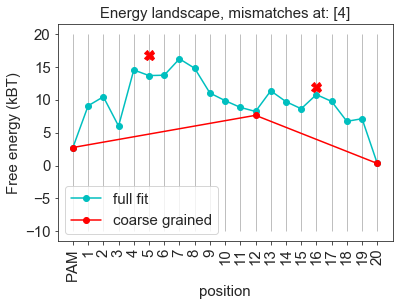

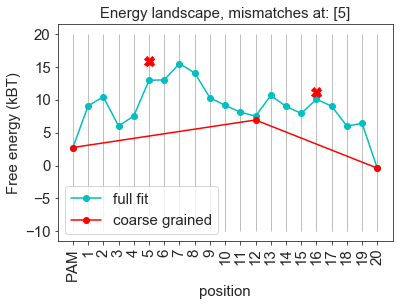

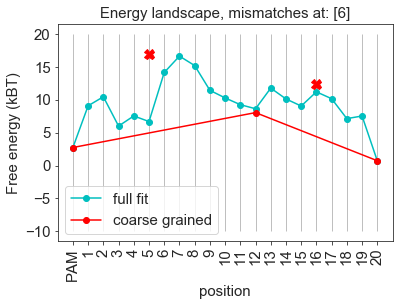

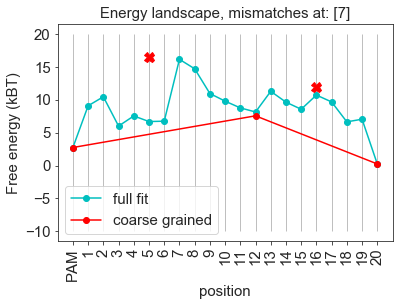

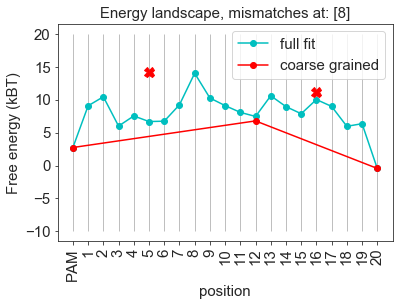

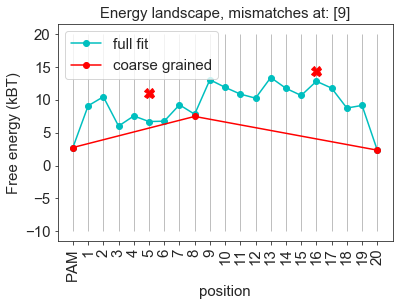

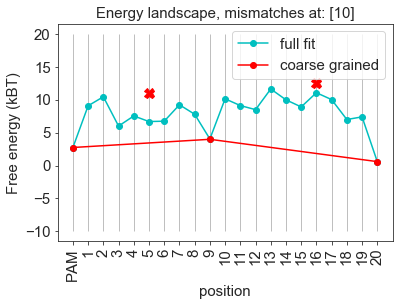

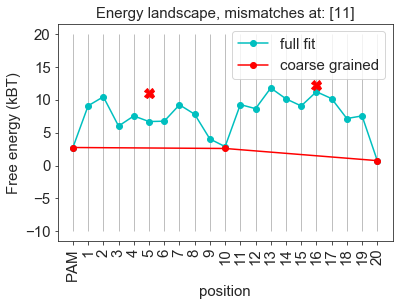

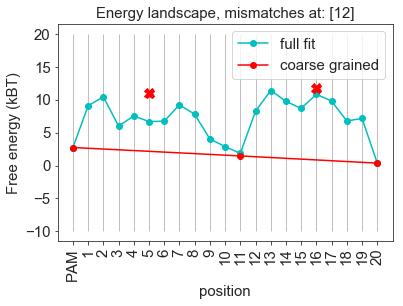

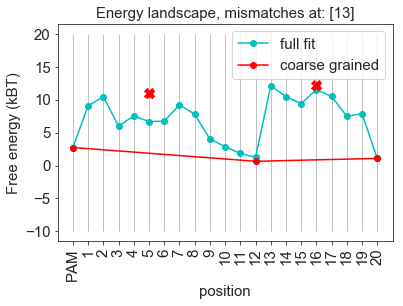

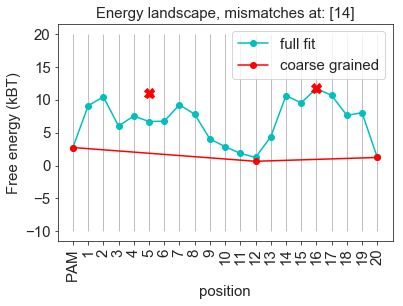

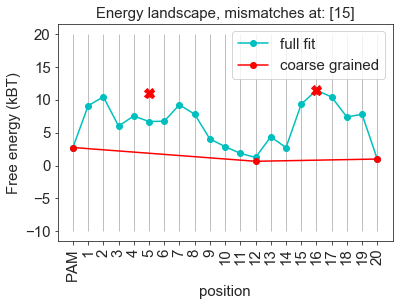

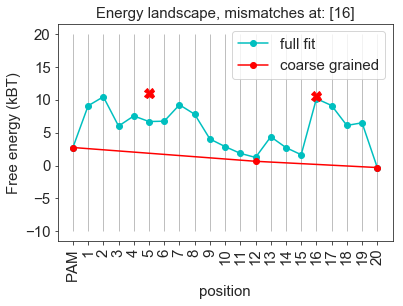

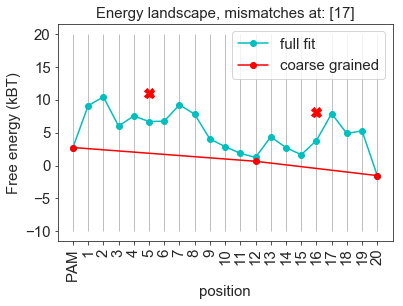

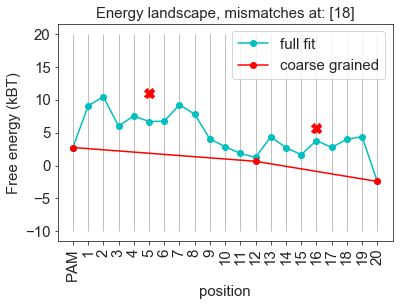

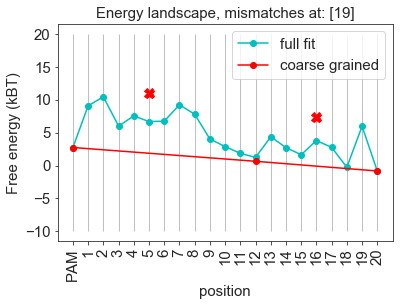

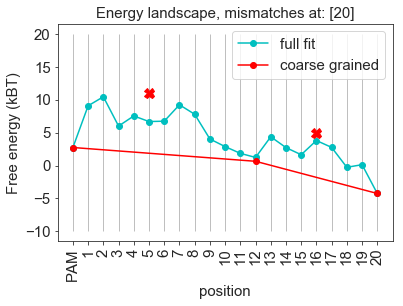

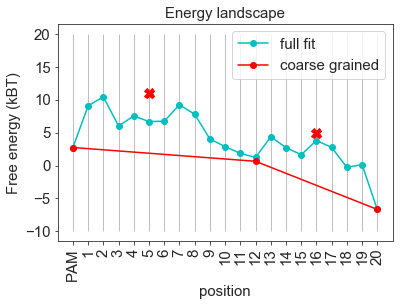

In [4]:
for i in range(1,22):
    ## Mismatch
    mismatch = [i]
    if i == 21:
        mismatch = []
    
    energies20 = energies.copy()
    for i in mismatch:
        energies20[i] -= energies20[i+20]
    
    rates_cg,energies_cg,Istate = cg.coarse_grain_4state(parameters_clv,model_ID_clv,mismatch,[7,13])
    energies_cg[0] = -energies[0]
    barrier1 = -np.log(rates_cg[0]/rates[1])
    barrier2 = -np.log(rates_cg[1]/rates[1])
    landscape4 = -np.cumsum(energies_cg)
    landscape20 = -np.cumsum(np.append(-energies20[0],energies20[1:21]))

    plt.figure()
    plot5, = plt.plot(range(0,21),landscape20,'c-o',label='full fit')
    plot1, = plt.plot([0,Istate,20],landscape4,'r-o',label='coarse grained')
    plt.plot([5,16],[barrier1+landscape4[0],barrier2+landscape4[1]],'rX',markersize=10)
    plt.legend(handles=[plot5,plot1],fontsize=15)
    plt.xlabel('position',fontsize=15)
    plt.ylabel('Free energy (kBT)',fontsize=15)
    plt.title('Energy landscape',fontsize=15)
    if len(mismatch) > 0:
        plt.title('Energy landscape, mismatches at: ' + str(mismatch),fontsize=15)
    plt.vlines(range(0,21),-10,20,color='grey',linewidth=0.5);
    plt.xticks(range(0,21),['PAM'] + range(1,21),fontsize=15,rotation='vertical');
    plt.yticks(fontsize=15);

## Coarse graining all fits, and comparing rates

38
3


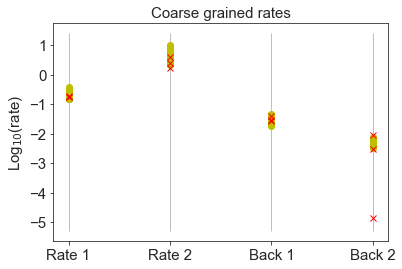

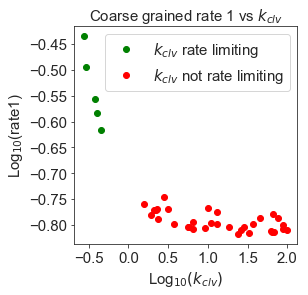

In [8]:
model_ID = 'Clv_Saturated_general_energies_v2+general_energies_no_kPR'; parnum = '44'
rates_list = []
cleave_list = []

mismatch = []
for i in range(1,51):
    filename = 'fit_18_7_2019_sim_' + str(i) + '.txt'
    path = '../fits_Stijn/18_7_2019/'
    data = pd.read_table(path+filename,index_col=False)
    chi = data.loc[:,'Potential']
    final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
    final_par_np = np.array(final_par.values)
    
    if np.min(chi)<295.:

        model_ID_clv,model_ID_on,parameters_clv,parameters_on = model.combined_model(final_par_np,model_ID)
        energies,rates = model.unpack_parameters(parameters_on,model_ID_on,20)
        _,rates_clv = model.unpack_parameters(parameters_clv,model_ID_clv,20)
        
        rates_cg,energies_cg,Istate = cg.coarse_grain_4state(parameters_clv,model_ID_clv,mismatch,[7,13])

        rates_list.append(np.log10(np.array(rates_cg)))
        cleave_list.append(np.log10(rates_clv[-1]))
print len(rates_list)

rates_list2 = []
cleave_list2 = []
for i in range(1,6):
    filename = 'fit_8_8_2019_sim_' + str(i) + '.txt'
    path = '../fits_Stijn/8_8_2019/'
    data = pd.read_table(path+filename,index_col=False)
    chi = data.loc[:,'Potential']
    final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
    final_par_np = np.array(final_par.values)
    
    if np.min(chi)<500.:

        model_ID_clv,model_ID_on,parameters_clv,parameters_on = model.combined_model(final_par_np,model_ID)
        energies,rates = model.unpack_parameters(parameters_on,model_ID_on,20)
        _,rates_clv = model.unpack_parameters(parameters_clv,model_ID_clv,20)
        
        rates_cg,energies_cg,Istate = cg.coarse_grain_4state(parameters_clv,model_ID_clv,mismatch,[7,13])

        rates_list2.append(np.log10(np.array(rates_cg)))
        cleave_list2.append(np.log10(rates_clv[-1]))
print len(rates_list2)


plt.figure(figsize = [6,4])
for i in range(len(rates_list)):
    plot1, = plt.plot(range(1,5),rates_list[i],'yo',linewidth=0,label='constrained $k_f$')
for i in range(len(rates_list2)):
    plot2, = plt.plot(range(1,5),rates_list2[i],'rx',linewidth=0,label='unconstrained $k_f$')
plt.title('Coarse grained rates',fontsize=15)
if len(mismatch) > 0:
    plt.title('Coarse grained rates, \nmismatches at: ' + str(mismatch),fontsize=15)
plt.vlines(range(1,5),-5.3,1.4,color='grey',linewidth=0.5);
plt.xticks(range(1,5),['Rate 1','Rate 2','Back 1','Back 2'],fontsize=15);
plt.ylabel('Log$_{10}$(rate)',fontsize=15)
plt.yticks(fontsize=15)
#plt.axis([0.5,2.5,-3.5,1.5])
#plt.legend(handles=[plot1,plot2],fontsize=15)

    
plt.figure(figsize=[4,4])
for i in range(len(rates_list)):
    if cleave_list[i]<0.:
        plot1, = plt.plot(cleave_list[i],rates_list[i][0],'go',linewidth=0,label='$k_{clv}$ rate limiting')
    if cleave_list[i]>0.:
        plot2, = plt.plot(cleave_list[i],rates_list[i][0],'ro',linewidth=0,label='$k_{clv}$ not rate limiting')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.title('Coarse grained rate 1 vs $k_{clv}$',fontsize=15)
plt.xlabel('Log$_{10}(k_{clv})$',fontsize=15)
plt.ylabel('Log$_{10}$(rate1)',fontsize=15)
plt.legend(handles=[plot1,plot2],fontsize=15)

## Predicting using coarse grained rates

Text(0,0.5,'Coarse model')

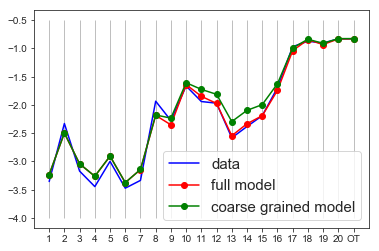

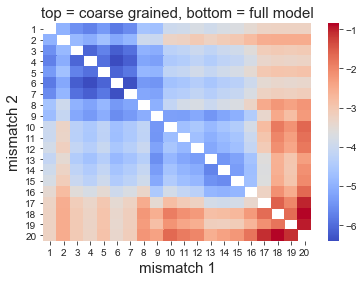

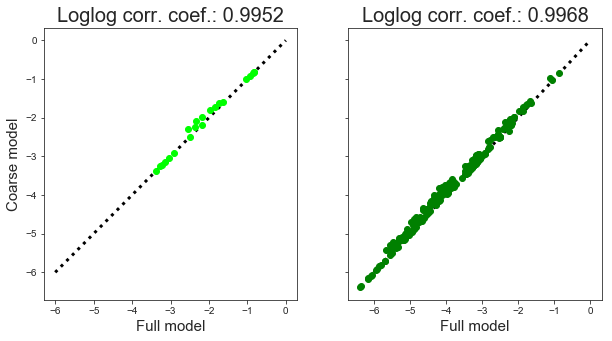

In [9]:
model_ID = 'Clv_Saturated_general_energies_v2+general_energies_no_kPR'; parnum = '44'

filename = 'fit_18_7_2019_sim_17.txt'
path = '../fits_Stijn/18_7_2019/'
data = pd.read_table(path+filename,index_col=False)
chi = data.loc[:,'Potential']
final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
final_par_np = np.array(final_par.values)

model_ID_clv,model_ID_on,parameters_clv,parameters_on = model.combined_model(final_par_np,model_ID)
energies,rates = model.unpack_parameters(parameters_on,model_ID_on,20)
_,rates_clv = model.unpack_parameters(parameters_clv,model_ID_clv,20)


kclv_full = []
kclv_coarse = []
for i in range(1,22):
    energies20 = energies.copy()

    ## Mismatch
    mismatch = [i]
    if i == 21:
        mismatch = []
    
    rates_cg,energies_cg,Istate = cg.coarse_grain_4state(parameters_clv,model_ID_clv,mismatch,[7,13])
        
    kclv_coarse.append(np.log10(cg.calc_clv_rate_4state(rates_cg,1000,rates_clv[-1],energies_cg[0])))
    kclv_full.append(np.log10(clv.calc_clv_rate_fast(parameters_clv,model_ID_clv,mismatch)))

plt.plot(range(1,22),kclv,color='b')
plt.plot(range(1,22),kclv_full,color='r',marker='o')
#plt.plot(range(1,22),kclv_coarse,color='b',marker='o')
plt.plot(range(1,22),kclv_coarse,color='g',marker='o')

plt.vlines(range(1,22),-4,-0.5,color='grey',linewidth=0.5)
plt.xticks(range(1,22),range(1,21)+['OT']);
plt.legend(['data','full model','coarse grained model'],fontsize=15)

doublefull = []
doublecoarse = []
double = np.zeros([20,20])
plt.figure()
for j in range(1,20):
    for a in range(j+1,21):
        energies20 = energies.copy()

        ## Mismatch
        mismatch = [j,a]
        
        rates_cg,energies_cg,Istate = cg.coarse_grain_4state(parameters_clv,model_ID_clv,mismatch,[7,13])
        
        predtemp = np.log10(cg.calc_clv_rate_4state(rates_cg,1000,rates_clv[-1],energies_cg[0]))
        double[j-1][a-1] = predtemp
        doublecoarse.append(predtemp)
        clvtemp = np.log10(clv.calc_clv_rate_fast(parameters_clv,model_ID_clv,[j,a]))
        double[a-1][j-1] = clvtemp
        doublefull.append(clvtemp)
        
double_df = pd.DataFrame(double, index=range(1, 21), columns=range(1, 21))
for i in range(1,21):
    double_df[i].loc[i]=np.nan
sns.heatmap(double_df, cmap='coolwarm', cbar=True)
plt.xlabel('mismatch 1', fontsize=15)
plt.ylabel('mismatch 2', fontsize=15)
plt.title('top = coarse grained, bottom = full model',fontsize=15)

f,ax = plt.subplots(1,2,sharey=True,figsize=[10,5])
ax[0].plot([-6.,0.],[-6.,0.],'k:',linewidth=3.)
ax[1].plot([-6.,0.],[-6.,0.],'k:',linewidth=3.)
ax[0].plot(kclv_full,kclv_coarse,color='lime',marker='o',linewidth=0.)
ax[1].plot(doublefull,doublecoarse,color='g',marker='o',linewidth=0.)
ax[0].set_title('Loglog corr. coef.: ' + str(np.round(np.corrcoef([kclv_full,kclv_coarse])[0][1],4)), fontsize=20)
ax[1].set_title('Loglog corr. coef.: '+ str(np.round(np.corrcoef([doublefull,doublecoarse])[0][1],4)), fontsize=20)
ax[0].set_xlabel('Full model',fontsize=15)
ax[1].set_xlabel('Full model',fontsize=15)
ax[0].set_ylabel('Coarse model',fontsize=15)
        

## 5-state?

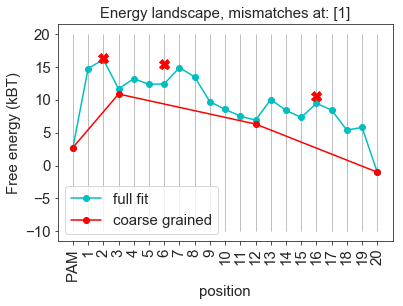

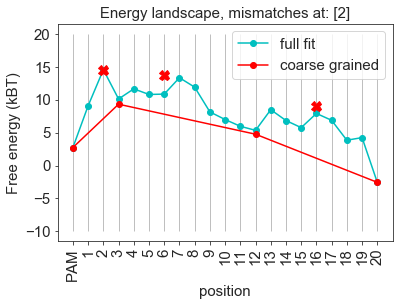

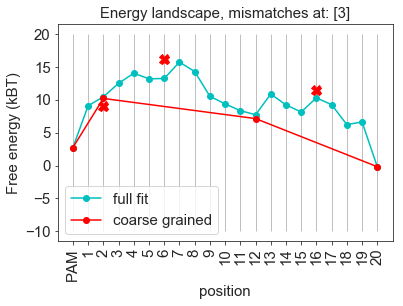

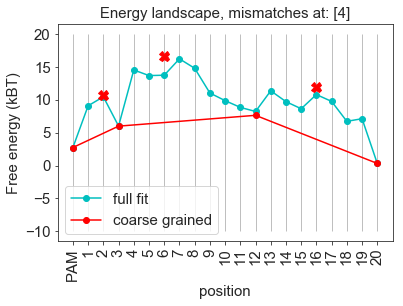

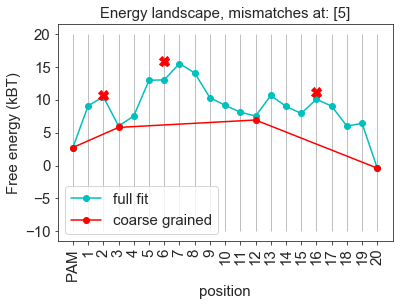

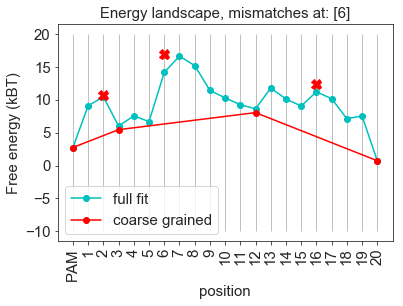

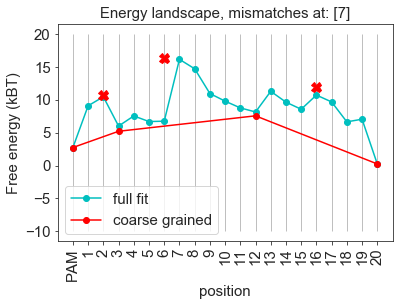

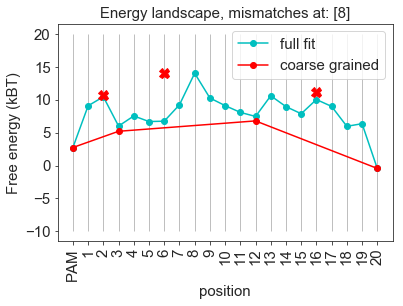

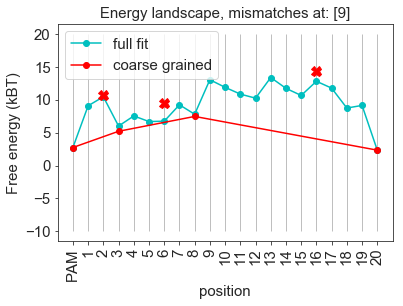

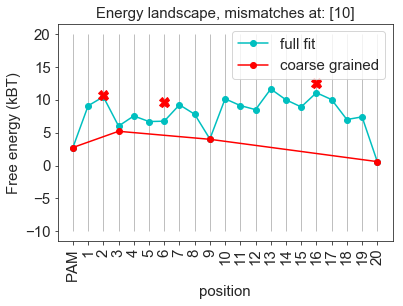

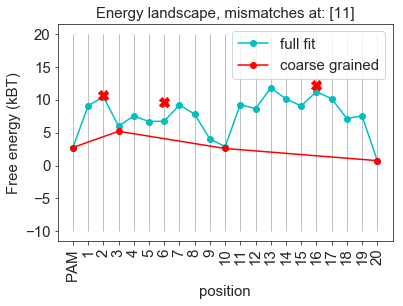

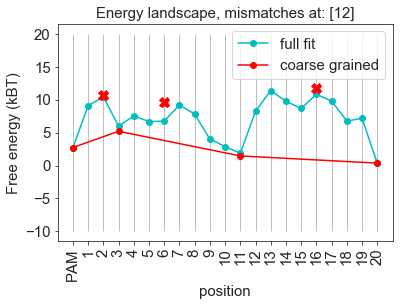

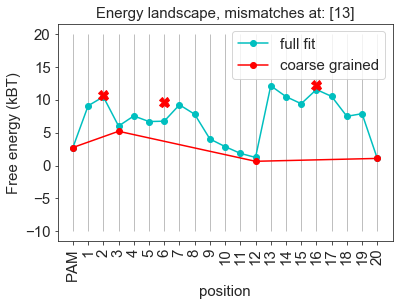

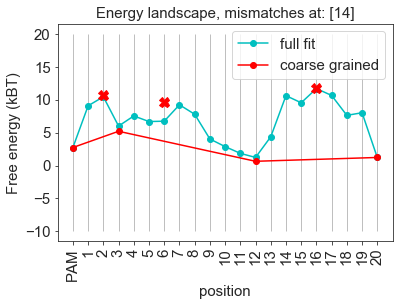

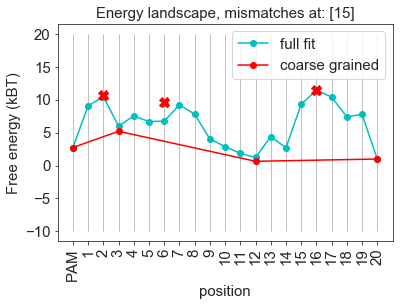

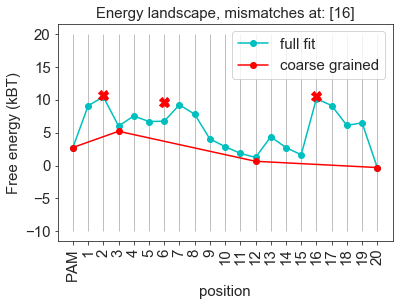

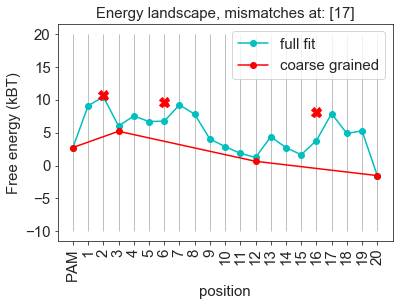

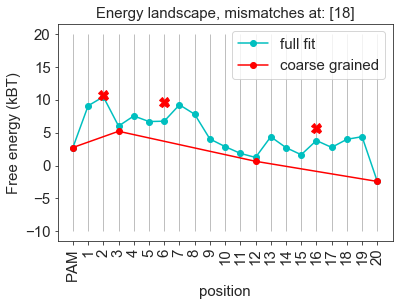

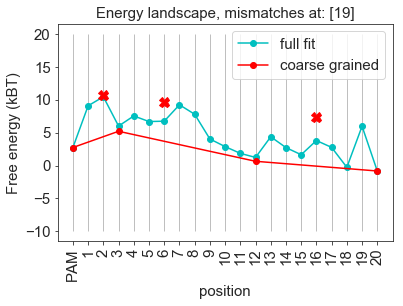

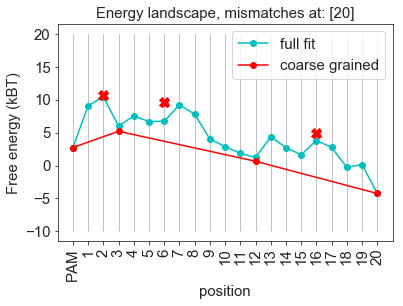

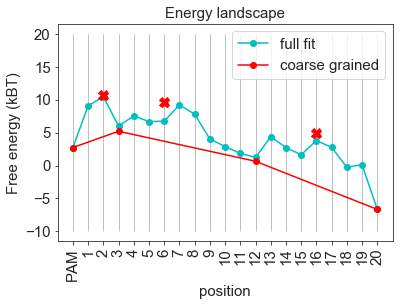

In [10]:
for i in range(1,22):
    ## Mismatch
    mismatch = [i]
    if i == 21:
        mismatch = []
    
    energies20 = energies.copy()
    for i in mismatch:
        energies20[i] -= energies20[i+20]
    
    rates_cg,energies_cg,Istate = cg.coarse_grain_5state(parameters_clv,model_ID_clv,mismatch,[2,7],[7,13])
    energies_cg[0] = -energies[0]
    barrier1 = -np.log(rates_cg[0]/rates[1])
    barrier2 = -np.log(rates_cg[1]/rates[1])
    barrier3 = -np.log(rates_cg[2]/rates[1])
    landscape4 = -np.cumsum(energies_cg)
    landscape20 = -np.cumsum(np.append(-energies20[0],energies20[1:21]))

    plt.figure()
    plot5, = plt.plot(range(0,21),landscape20,'c-o',label='full fit')
    plot1, = plt.plot([0,Istate[0],Istate[1],20],landscape4,'r-o',label='coarse grained')
    plt.plot([2,6,16],[barrier1+landscape4[0],barrier2+landscape4[1],barrier3+landscape4[2]],'rX',markersize=10)
    plt.legend(handles=[plot5,plot1],fontsize=15)
    plt.xlabel('position',fontsize=15)
    plt.ylabel('Free energy (kBT)',fontsize=15)
    plt.title('Energy landscape',fontsize=15)
    if len(mismatch) > 0:
        plt.title('Energy landscape, mismatches at: ' + str(mismatch),fontsize=15)
    plt.vlines(range(0,21),-10,20,color='grey',linewidth=0.5);
    plt.xticks(range(0,21),['PAM'] + range(1,21),fontsize=15,rotation='vertical');
    plt.yticks(fontsize=15);

38
3


(array([-6., -4., -2.,  0.,  2.,  4.]), <a list of 6 Text yticklabel objects>)

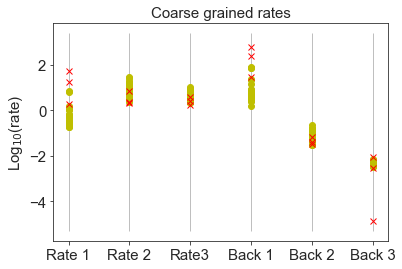

In [12]:
model_ID = 'Clv_Saturated_general_energies_v2+general_energies_no_kPR'; parnum = '44'
rates_list = []
cleave_list = []

mismatch = []
for i in range(1,51):
    filename = 'fit_18_7_2019_sim_' + str(i) + '.txt'
    path = '../fits_Stijn/18_7_2019/'
    data = pd.read_table(path+filename,index_col=False)
    chi = data.loc[:,'Potential']
    final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
    final_par_np = np.array(final_par.values)
    
    if np.min(chi)<295.:

        model_ID_clv,model_ID_on,parameters_clv,parameters_on = model.combined_model(final_par_np,model_ID)
        energies,rates = model.unpack_parameters(parameters_on,model_ID_on,20)
        _,rates_clv = model.unpack_parameters(parameters_clv,model_ID_clv,20)
        
        rates_cg,energies_cg,Istate = cg.coarse_grain_5state(parameters_clv,model_ID_clv,mismatch,[2,7],[7,13])

        rates_list.append(np.log10(np.array(rates_cg)))
        cleave_list.append(np.log10(rates_clv[-1]))
print len(rates_list)

rates_list2 = []
cleave_list2 = []
for i in range(1,6):
    filename = 'fit_8_8_2019_sim_' + str(i) + '.txt'
    path = '../fits_Stijn/8_8_2019/'
    data = pd.read_table(path+filename,index_col=False)
    chi = data.loc[:,'Potential']
    final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
    final_par_np = np.array(final_par.values)
    
    if np.min(chi)<500.:

        model_ID_clv,model_ID_on,parameters_clv,parameters_on = model.combined_model(final_par_np,model_ID)
        energies,rates = model.unpack_parameters(parameters_on,model_ID_on,20)
        _,rates_clv = model.unpack_parameters(parameters_clv,model_ID_clv,20)
        
        rates_cg,energies_cg,Istate = cg.coarse_grain_5state(parameters_clv,model_ID_clv,mismatch,[2,7],[7,13])

        rates_list2.append(np.log10(np.array(rates_cg)))
        cleave_list2.append(np.log10(rates_clv[-1]))
print len(rates_list2)


plt.figure(figsize = [6,4])
for i in range(len(rates_list)):
    plot1, = plt.plot(range(1,7),rates_list[i],'yo',linewidth=0,label='constrained $k_f$')
for i in range(len(rates_list2)):
    plot2, = plt.plot(range(1,7),rates_list2[i],'rx',linewidth=0,label='unconstrained $k_f$')
plt.title('Coarse grained rates',fontsize=15)
if len(mismatch) > 0:
    plt.title('Coarse grained rates, \nmismatches at: ' + str(mismatch),fontsize=15)
plt.vlines(range(1,7),-5.3,3.4,color='grey',linewidth=0.5);
plt.xticks(range(1,7),['Rate 1','Rate 2','Rate3','Back 1','Back 2','Back 3'],fontsize=15);
plt.ylabel('Log$_{10}$(rate)',fontsize=15)
plt.yticks(fontsize=15)
#plt.axis([0.5,2.5,-3.5,1.5])
#plt.legend(handles=[plot1,plot2],fontsize=15)

Text(0,0.5,'Coarse model')

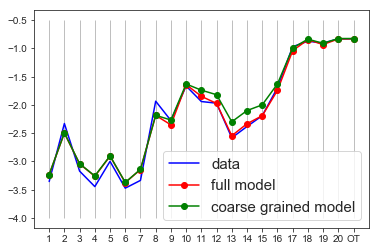

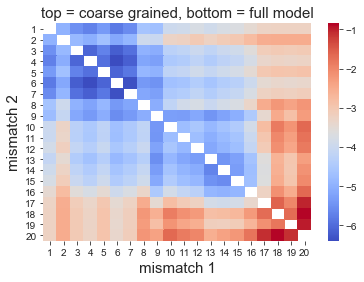

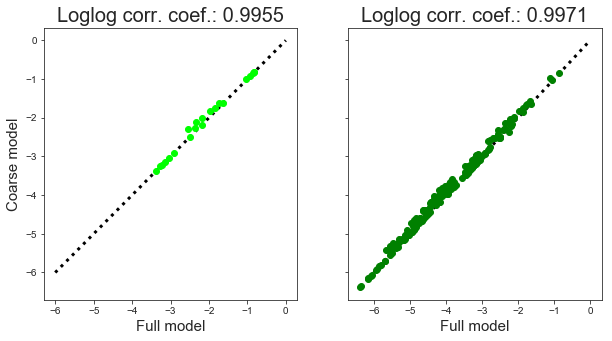

In [13]:
model_ID = 'Clv_Saturated_general_energies_v2+general_energies_no_kPR'; parnum = '44'

filename = 'fit_18_7_2019_sim_17.txt'
path = '../fits_Stijn/18_7_2019/'
data = pd.read_table(path+filename,index_col=False)
chi = data.loc[:,'Potential']
final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
final_par_np = np.array(final_par.values)

model_ID_clv,model_ID_on,parameters_clv,parameters_on = model.combined_model(final_par_np,model_ID)
energies,rates = model.unpack_parameters(parameters_on,model_ID_on,20)
_,rates_clv = model.unpack_parameters(parameters_clv,model_ID_clv,20)


kclv_full = []
kclv_coarse = []
for i in range(1,22):
    energies20 = energies.copy()

    ## Mismatch
    mismatch = [i]
    if i == 21:
        mismatch = []
    
    rates_cg,energies_cg,Istate = cg.coarse_grain_5state(parameters_clv,model_ID_clv,mismatch,[2,7],[7,13])
        
    kclv_coarse.append(np.log10(cg.calc_clv_rate_5state(rates_cg,1000,rates_clv[-1],energies_cg[0])))
    kclv_full.append(np.log10(clv.calc_clv_rate_fast(parameters_clv,model_ID_clv,mismatch)))

plt.plot(range(1,22),kclv,color='b')
plt.plot(range(1,22),kclv_full,color='r',marker='o')
#plt.plot(range(1,22),kclv_coarse,color='b',marker='o')
plt.plot(range(1,22),kclv_coarse,color='g',marker='o')

plt.vlines(range(1,22),-4,-0.5,color='grey',linewidth=0.5)
plt.xticks(range(1,22),range(1,21)+['OT']);
plt.legend(['data','full model','coarse grained model'],fontsize=15)

doublefull = []
doublecoarse = []
double = np.zeros([20,20])
plt.figure()
for j in range(1,20):
    for a in range(j+1,21):
        energies20 = energies.copy()

        ## Mismatch
        mismatch = [j,a]
        
        rates_cg,energies_cg,Istate = cg.coarse_grain_5state(parameters_clv,model_ID_clv,mismatch,[2,7],[7,13])
        
        predtemp = np.log10(cg.calc_clv_rate_5state(rates_cg,1000,rates_clv[-1],energies_cg[0]))
        double[j-1][a-1] = predtemp
        doublecoarse.append(predtemp)
        clvtemp = np.log10(clv.calc_clv_rate_fast(parameters_clv,model_ID_clv,[j,a]))
        double[a-1][j-1] = clvtemp
        doublefull.append(clvtemp)
        
double_df = pd.DataFrame(double, index=range(1, 21), columns=range(1, 21))
for i in range(1,21):
    double_df[i].loc[i]=np.nan
sns.heatmap(double_df, cmap='coolwarm', cbar=True)
plt.xlabel('mismatch 1', fontsize=15)
plt.ylabel('mismatch 2', fontsize=15)
plt.title('top = coarse grained, bottom = full model',fontsize=15)

f,ax = plt.subplots(1,2,sharey=True,figsize=[10,5])
ax[0].plot([-6.,0.],[-6.,0.],'k:',linewidth=3.)
ax[1].plot([-6.,0.],[-6.,0.],'k:',linewidth=3.)
ax[0].plot(kclv_full,kclv_coarse,color='lime',marker='o',linewidth=0.)
ax[1].plot(doublefull,doublecoarse,color='g',marker='o',linewidth=0.)
ax[0].set_title('Loglog corr. coef.: ' + str(np.round(np.corrcoef([kclv_full,kclv_coarse])[0][1],4)), fontsize=20)
ax[1].set_title('Loglog corr. coef.: '+ str(np.round(np.corrcoef([doublefull,doublecoarse])[0][1],4)), fontsize=20)
ax[0].set_xlabel('Full model',fontsize=15)
ax[1].set_xlabel('Full model',fontsize=15)
ax[0].set_ylabel('Coarse model',fontsize=15)

## Load Data

In [2]:
filename = 'WT_cleavage_rate_and_y0_Canonical_OT-r_0-2.csv'
path_to_data = '../data_nucleaseq_Finkelsteinlab/targetE/'

xdata, ydata, yerr = processing.prepare_multiprocessing_combined('1',filename,'../Data_Boyle/',path_to_data,True,False,True)
_, ydatafull, yerrfull = processing.prepare_multiprocessing_combined('1',filename,'../Data_Boyle/',path_to_data,False)

filename_daba = 'cas9-target-e-replicate-1-delta-abas_Canonical_OT-r_0-20.csv'
path_to_data_daba = '../data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/'

filename_aba = 'TargetE-dCas9_AbsoluteABA_Canonical_OT-r_0-2.csv'
path_to_data_aba = '../data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/'

_, ydata_daba, yerr_daba = processing.prepare_multiprocessing_combined_delta_aba(filename_daba,filename,path_to_data_daba,path_to_data,False)
_, ydatawa_daba, yerrwa_daba = processing.prepare_multiprocessing_combined_delta_aba(filename_daba,filename,path_to_data_daba,path_to_data,True)

_, ydata_aba, yerr_aba = processing.prepare_multiprocessing_combined_aba(filename_aba,filename,path_to_data_aba,path_to_data,False)
_, ydatawa_aba, yerrwa_aba = processing.prepare_multiprocessing_combined_aba(filename_aba,filename,path_to_data_aba,path_to_data,True)

kclv = []
kon = []
erron = []
aba = []
daba = []
i = 1
while i < 20+1:
    for a in range(len(xdata)):
        if len(xdata[a])==1 and xdata[a][0]==i:
            kclv.append(ydata[a][0][0])
            kon.append((ydata[a][1][0]))
            aba.append((ydatawa_aba[a][1][0]))
            daba.append((ydatawa_daba[a][1][0]))
            erron.append((yerr[a][1][0]))
            i = i + 1
    
kclv.append(ydata[0][0][0])
kclv = np.array(kclv)
kon.append((ydata[0][1][0]))
kon = np.array(kon)
aba.append((ydatawa_aba[0][1][0]))
aba = np.array(aba)
daba.append(0.0)
daba = np.array(daba)
erron.append(yerr[0][1][0])
erron = np.array(erron)


k_double = np.zeros([20,20])
on_double = np.zeros([20,20])
aba_double = np.zeros([20,20])
daba_double = np.zeros([20,20])

for a in range(len(xdata)):
    if len(xdata[a])==2:
        i = xdata[a][0]
        j = xdata[a][1]
        k_double[j-1,i-1] = (ydata[a][0][0])
        aba_double[j-1,i-1] = ydatawa_aba[a][1][0]
        daba_double[j-1,i-1] = ydatawa_daba[a][1][0]
        if len(ydata[a][1])>0:
            on_double[j-1,i-1] = (ydata[a][1][0])
        else:
            on_double[j-1,i-1] = np.nan
        
k_double_df = pd.DataFrame(k_double, index=range(1, 21), columns=range(1, 21))
on_double_df = pd.DataFrame(on_double, index=range(1, 21), columns=range(1, 21))
aba_double_df = pd.DataFrame(aba_double, index=range(1, 21), columns=range(1, 21))
daba_double_df = pd.DataFrame(daba_double, index=range(1, 21), columns=range(1, 21))

In [ ]:
model_id = 'four_state_model_clv_rates+four_state_model_on_rates'; parnum = '27'

conc = np.array([0.1, 0.3, 1, 3, 10, 30, 100, 300])
ref = 10. # in nanomolair
_,otaba = clv_toy.calc_clv_aba(parameters_CG,model_id,[],conc,ref)
print 'OT-ABA: ' + str(otaba)

k = np.zeros(21)
on = np.zeros(21)
for i in range(1,21):
    mismatch_positions = [i]
    k[i-1],on[i-1] = np.log10(clv_toy.calc_clv_on(parameters_CG_on,model_id,mismatch_positions))
k[-1],on[-1] = np.log10(clv_toy.calc_clv_on(parameters_CG_on,model_id,[]))

abafit = np.zeros(21)
dabafit = np.zeros(21)
for i in range(1,21):
    mismatch_positions = [i]
    _,abafit[i-1] = clv_toy.calc_clv_aba(parameters_CG,model_id,mismatch_positions,conc,ref)
    dabafit[i-1] = abafit[i-1] - otaba
abafit[-1] = otaba
dabafit[-1] = 0.

f,ax = plt.subplots(4,2,sharey=False,figsize=[12,18])
    
ax[0][0].plot(range(1,22),k,marker='o',color='blue')
ax[0][0].set_xticks(range(1,22));
ax[0][0].set_xticklabels(range(1,21)+['OT'])
ax[0][0].vlines(range(1,22),-6,0,linewidth=0.5,color='grey')
ax[0][0].plot(range(1,22),kclv,marker='o',color='red')
ax[0][0].legend(['prediction','data'],fontsize=15)
ax[0][0].set_title('Cleavage')

ax[1][0].plot(range(1,22),on,marker='o',color='blue')
#ax[1][0].errorbar(range(1,22),kon,erron*10,marker='o',color='red')
ax[1][0].set_xticks(range(1,22));
ax[1][0].set_xticklabels(range(1,21)+['OT'])
ax[1][0].vlines(range(1,22),-5,-3,linewidth=0.5,color='grey')
ax[1][0].plot(range(1,22),kon,marker='o',color='red')
ax[1][0].legend(['prediction','data'],fontsize=15)
ax[1][0].set_title('On-rate')
for i in range(21):
    if i+1==6 or i+1==7:
        ax[0][1].plot(i+1,kon[i],marker='X',color='k',markersize=10)

k_double = np.zeros([20,20])
on_double = np.zeros([20,20])
for i in range(1,20):
    for j in range(i+1,21):
        mismatch_positions = [i,j]
        k_double[i-1][j-1],on_double[i-1][j-1] = np.log10(clv_toy.calc_clv_on(parameters_CG_on,model_id,mismatch_positions))
        
k_df = pd.DataFrame(k_double, index=range(1, 21), columns=range(1, 21))
k_df = k_df + k_double_df
for i in range(1,21):
    k_df[i].loc[i]=np.nan
    
on_df = pd.DataFrame(on_double, index=range(1, 21), columns=range(1, 21))
on_df = on_df + on_double_df
for i in range(1,21):
    on_df[i].loc[i]=np.nan
    
    
aba_double = np.zeros([20,20])
daba_double = np.zeros([20,20])
for i in range(1,20):
    for j in range(i+1,21):
        mismatch_positions = [i,j]
        _,aba_double[i-1][j-1] = clv_toy.calc_clv_aba(parameters_CG,model_id,mismatch_positions,conc,ref)
        daba_double[i-1][j-1] = aba_double[i-1][j-1] - otaba
        
aba_df = pd.DataFrame(aba_double, index=range(1, 21), columns=range(1, 21))
aba_df = aba_df + aba_double_df
for i in range(1,21):
    aba_df[i].loc[i]=np.nan
    
daba_df = pd.DataFrame(daba_double, index=range(1, 21), columns=range(1, 21))
daba_df = daba_df + daba_double_df
for i in range(1,21):
    daba_df[i].loc[i]=np.nan
    
sns.heatmap(k_df, cmap='coolwarm', cbar=True,ax=ax[0][1],vmin=-5,vmax=-1)
plt.xlabel('mismatch 1', fontsize=15)
plt.ylabel('mismatch 2', fontsize=15)

sns.heatmap(on_df, cmap='coolwarm', cbar=True,ax=ax[1][1],vmin=-5,vmax=-3.5)
plt.xlabel('mismatch 1', fontsize=15)
plt.ylabel('mismatch 2', fontsize=15)



ax[2][0].plot(range(1,22),abafit,marker='o',color='blue')
ax[2][0].set_xticks(range(1,22));
ax[2][0].set_xticklabels(range(1,21)+['OT'])
ax[2][0].vlines(range(1,22),2,6,linewidth=0.5,color='grey')
ax[2][0].plot(range(1,22),aba,marker='o',color='red')
ax[2][0].legend(['prediction','data'],fontsize=15)
ax[2][0].set_title('ABA')

ax[3][0].plot(range(1,22),dabafit,marker='o',color='blue')
#ax[3][0].errorbar(range(1,22),kon,erron*10,marker='o',color='red')
ax[3][0].set_xticks(range(1,22));
ax[3][0].set_xticklabels(range(1,21)+['OT'])
ax[3][0].vlines(range(1,22),-1,3,linewidth=0.5,color='grey')
ax[3][0].plot(range(1,22),daba,marker='o',color='red')
ax[3][0].legend(['prediction','data'],fontsize=15)
ax[3][0].set_title('Delta-ABA')

sns.heatmap(aba_df, cmap='coolwarm', cbar=True,ax=ax[2][1])#,vmin=2,vmax=6)
plt.xlabel('mismatch 1', fontsize=15)
plt.ylabel('mismatch 2', fontsize=15)

sns.heatmap(daba_df, cmap='coolwarm', cbar=True,ax=ax[3][1])#,vmin=-1,vmax=3)
plt.xlabel('mismatch 1', fontsize=15)
plt.ylabel('mismatch 2', fontsize=15)